<a href="https://colab.research.google.com/github/filbertmiko/Analysis-of-COVID-19-and-its-Impact-on-IHSG-and-Rupiah/blob/main/Final_Year_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Packages**

In [ ]:
#Import required packages
% pip install yfinance
% pip install pandas
% pip install tabula-py
% pip install kaggle
#% pip install googletrans==3.1.0a0

import matplotlib.pyplot as plt
import numpy as np
import tabula
import pandas as pd
import yfinance as yf
import io
import os
import json
import zipfile
from google.colab import files
from google.colab import data_table
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
#from googletrans import Translator

# **Connect to Github**

In [ ]:
#cloning github repository
!git clone https://github.com/filbertmiko/Analysis-of-COVID-19-and-its-Impact-on-IHSG-and-Rupiah.git

fatal: destination path 'Analysis-of-COVID-19-and-its-Impact-on-IHSG-and-Rupiah' already exists and is not an empty directory.


In [ ]:
#Move directory to cloned git repository
%cd /content/Analysis-of-COVID-19-and-its-Impact-on-IHSG-and-Rupiah
!pwd

/content/Analysis-of-COVID-19-and-its-Impact-on-IHSG-and-Rupiah
/content/Analysis-of-COVID-19-and-its-Impact-on-IHSG-and-Rupiah


In [ ]:
#Importing Kaggle Api json file using aslisabanci's code from github as a reference
#Importing dataset called covid19-indonesia created by user hendratno

#create the .kaggle directory and put credentials json file into it
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle/

#so that the kaggle.json which has the credentials file cannot be read by others
!chmod 600 /root/.kaggle/kaggle.json 

#downloads the zip file using the API provided by Kaggle
!kaggle datasets download -d hendratno/covid19-indonesia

#unzipping the zip files
!unzip \*.zip

covid19-indonesia.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  covid19-indonesia.zip
replace covid_19_indonesia_time_series_all.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


# **Extract**

**Extract datasets from different data sources**



*   Our World in Data
*   CSV files that are converted from PDF that are stored in Github
*   COVID Open Data



In [ ]:
#File Paths for each sources
file_path_OWID = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv"
file_path_COVID_OPEN_DATA = "https://storage.googleapis.com/covid19-open-data/v2/by-sex.csv"
file_path_GRS = "https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv"
file_path_demographics = "https://storage.googleapis.com/covid19-open-data/v2/demographics.csv"
file_path_geography = "https://storage.googleapis.com/covid19-open-data/v2/geography.csv"
file_path_IQ = "/content/Analysis-of-COVID-19-and-its-Impact-on-IHSG-and-Rupiah/countriesByIQ.csv"
file_path_PR = "/content/Analysis-of-COVID-19-and-its-Impact-on-IHSG-and-Rupiah/povertyRate.csv"
file_path_index = "https://storage.googleapis.com/covid19-open-data/v2/index.csv"
file_path_indonesia = "/content/Analysis-of-COVID-19-and-its-Impact-on-IHSG-and-Rupiah/covid_19_indonesia_time_series_all.csv"
file_path_epidemiology = "https://storage.googleapis.com/covid19-open-data/v2/epidemiology.csv"

#Reads in the csv from each respective URL
COVID_df = pd.read_csv(file_path_OWID)
index_df = pd.read_csv(file_path_index)
demographics_df = pd.read_csv(file_path_demographics)
geo_df = pd.read_csv(file_path_geography)
iq_per_country_df = pd.read_csv(file_path_IQ)
poverty_rate_df = pd.read_csv(file_path_PR)
indonesia_df = pd.read_csv(file_path_indonesia)
worldwide_ts_df = pd.read_csv(file_path_epidemiology)
GR_df = pd.read_csv(file_path_GRS)

initial_df_list = ['COVID_df', 'index_df', 'demographics_df', 'geo_df',
                   'iq_per_country_df', 'poverty_rate_df', 'indonesia_df',
                   'worldwide_ts_df', 'GR_df']

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#data_table.DataTable(index_df)

# **Clean**

**Data Cleansing**

1.   Removing Unwanted Columns
2.   Only Getting Wanted Columns
3.   Replace NaNs with 0 (when suitable)
4.   Rename Columns
5.   Change data type to the correct ones
6.   Fix capitalisation
7.   Remove rows that include unwanted value
8.   Translate elements into English





In [ ]:
#function to check if dataframes have any nulls
def df_contains_null():
  """
  Returns a list of dataframes that have nulls

  This function checks if each dataframes have any nulls. If it does,
  it will be appended to a list. The function will then return that
  list of dataframes that have nulls
  """

  null_df = []
  if COVID_df.isnull().values.any():
    null_df.append("COVID_df")
  if index_df.isnull().values.any():
    null_df.append('index_df')
  if demographics_df.isnull().values.any():
    null_df.append('demographics_df')
  if geo_df.isnull().values.any():
    null_df.append('geo_df')
  if iq_per_country_df.isnull().values.any():
    null_df.append('iq_per_country_df')
  if poverty_rate_df.isnull().values.any():
    null_df.append('poverty_rate_df')
  if indonesia_df.isnull().values.any():
    null_df.append('indonesia_df')
  if worldwide_ts_df.isnull().values.any():
    null_df.append('worldwide_ts_df')
  if GR_df.isnull().values.any():
    null_df.append('GR_df')
  
  return null_df

print("DFs with nulls:")
print(df_contains_null())

DFs with nulls:
['COVID_df', 'index_df', 'demographics_df', 'geo_df', 'iq_per_country_df', 'indonesia_df', 'worldwide_ts_df', 'GR_df']


In [ ]:
#Constants
DATE_FORMAT = '%Y-%m-%d'

#unwanted columns from COVID_df
remove_COVID_df_columns = ['reproduction_rate', 'icu_patients', 'icu_patients_per_million', 'hosp_patients', 'hosp_patients_per_million', 
                             'weekly_icu_admissions','weekly_icu_admissions_per_million', 'weekly_hosp_admissions', 'weekly_hosp_admissions_per_million', 
                             'new_cases_smoothed','new_deaths_smoothed', 'new_cases_smoothed_per_million','new_deaths_smoothed_per_million',
                             'new_tests_smoothed', 'new_tests_smoothed_per_thousand','new_vaccinations_smoothed', 
                             'new_vaccinations_smoothed_per_million', 'female_smokers', 'male_smokers']

#Remove unwanted columns for COVID_df
COVID_df = COVID_df.drop(remove_COVID_df_columns, axis=1)

#Rename location column to 'country_name'
COVID_df = COVID_df.rename(columns={'location': 'country_name'})

#Reformat date into the correct type
COVID_df['date'] = pd.to_datetime(COVID_df.date, format=DATE_FORMAT)

#Replace NaN with 0
COVID_df.fillna(0, inplace=True)

#Unwanted columns from iq_per_country_df
remove_iq_df_columns = ['rank', 'pop2020']
iq_per_country_df = iq_per_country_df.drop(remove_iq_df_columns, axis=1)
iq_per_country_df = iq_per_country_df.rename(columns={'country': 'country_name',
                                                           'iq': 'average_iq'})

#Capitalize the first letter for iq_per_country_df since the original file had
#all the country names in small letters
iq_per_country_df['country_name'] = iq_per_country_df['country_name'].str.capitalize()

#Sort the dataframe alphabetically 
iq_per_country_df = iq_per_country_df.sort_values('country_name')

In [ ]:
#Drops rows that 
index_df.dropna(subset = ["datacommons"], inplace=True)

#Change the type of key into string
index_df['key'] = index_df['key'].astype('str')

#Gets countries only from index dataframe.
#Length is set to 2 because countries only have 2 characters as key such as 
#ID, US, CH, TH, SG while the regions will contain extensions such as ID_JK, ID_JB
mask = index_df['key'].str.len() == 2
index_countries_df = index_df.loc[mask].copy()
index_countries_df.reset_index(drop=True)

#Only gets the wanted columns from index_df
wanted_index_columns = ['key', 'country_name']
index_df = index_df[wanted_index_columns]

#Replace NaNs with 0 if there are any
demographics_df.fillna(0, inplace=True)

#Only gets the wanted columns from demographics_df
wanted_demographics_columns = ['key','rural_population', 'urban_population']
demographics_df = demographics_df[wanted_demographics_columns]

#Only gets the wanted columns from geo_df
wanted_geo_columns = ['key', 'longitude', 'latitude']
geo_df = geo_df[wanted_geo_columns]

#Gets countries only from geo_df
mask = geo_df['key'].str.len() == 2
geo_df = geo_df.loc[mask]
geo_df.reset_index(drop=True)

#Drop rows with NaNs
geo_df = geo_df.dropna()

#Drops unwanted columns from poverty_rate_df 
poverty_rate_df = poverty_rate_df.drop(['pop2020'], axis=1)

#Sorts the table by sorting the country names alphabetically
poverty_rate_df = poverty_rate_df.sort_values('country')

#Renames the columns so that it will be in the same format as the other dataframes
poverty_rate_df = poverty_rate_df.rename(columns={'povertyRate': 'poverty_rate', 
                                                  'country': 'country_name'})

#Remove unwanted columns
unwanted_indonesia_df_columns = ['New Cases', 'New Deaths', 'New Recovered', 'New Active Cases',
                                 'Total Cases', 'Total Deaths', 'Total Recovered', 'Total Active Cases',
                                 'Location Level', 'City or Regency', 'Country', 'Continent', 'Time Zone',
                                 'Special Status', 'Total Regencies', 'Total Cities', 'Total Districts',
                                 'Growth Factor of New Cases', 'Growth Factor of New Deaths', 'Area (km2)',
                                 'Total Urban Villages', 'Total Rural Villages']
indonesia_df = indonesia_df.drop(unwanted_indonesia_df_columns, axis=1)

#Change format of ISO code to be uniform with the other datasets
indonesia_df['Location ISO Code'] = indonesia_df['Location ISO Code'].replace('-', '_', regex=True)

#Rename indonesia_df columns so it will be in the same format as the other dataframes
indonesia_df = indonesia_df.rename(columns={'Date': 'date', 'Location ISO Code': 'key',
                                            'Location': 'location', 'Province': 'province',
                                            'Island': 'island', 'Total Urban Villages': 'total_urban_villages',
                                            'Total Rural Villages': 'total_rural_villages', 'Population': 'population',
                                            'Population Density': 'population_density', 'Longitude': 'longitude',
                                            'Latitude': 'latitude', 'New Cases Per Million': 'new_cases_per_million',
                                            'Total Cases Per Million': 'total_cases_per_million',
                                            'New Deaths Per Million': 'new_deaths_per_million',
                                            'Total Deaths per Million': 'total_deaths_per_million', 
                                            'Case Fatality Rate': 'CFR', 'Case Recovered Rate': 'case_recovered_rate'})

#Change date format to DATE_FORMAT
indonesia_df['date'] = pd.to_datetime(indonesia_df['date'])
indonesia_df['date'].dt.strftime(DATE_FORMAT)

#Remove unwanted records
#mask = indonesia_df['key'] != "IDN"
#indonesia_df = indonesia_df.loc[mask]

#Replace NaNs with 0
worldwide_ts_df.fillna(0, inplace=True)

#Change the data type to DATE_FORMAT
GR_df['Date'] = pd.to_datetime(GR_df['Date'].astype(str), format=DATE_FORMAT)

#Renames the columns so that it will be in the same format as the other dataframes
GR_df = GR_df.rename(columns={'CountryName': 'country_name', 'CountryCode': 'key',
                              'RegionName': 'region_name', 'Date': 'date', 'StringencyIndex': 'stringency_index',
                              'StringencyIndexForDisplay': 'stringency_index_for_display',
                              'StringencyLegacyIndex': 'stringency_legacy_index', 
                              'StringencyLegacyIndexForDisplay': 'stringency_legacy_index_for_display',
                              'GovernmentResponseIndex': 'government_response_index',
                              'GovernmentResponseIndexForDisplay': 'government_response_index_for_display',
                              'ContainmentHealthIndex': 'containment_health_index', 
                              'ContainmentHealthIndexForDisplay': 'containment_health_index_for_display',
                              'EconomicSupportIndex': 'economic_support_index',
                              'EconomicSupportIndexForDisplay': 'economic_support_index_for_display'})

#Gets only the national data. Exclude any regional data
GR_df = GR_df.loc[GR_df.Jurisdiction == 'NAT_TOTAL']

#Rename columns in worldwide_ts_df so it can be uniform with the other dataframes
worldwide_ts_df = worldwide_ts_df.rename(columns={'new_confirmed': 'new_cases', 'new_deceased': 'new_deaths',
                                                  'total_confirmed': 'total_cases', 'total_deceased': 'total_deaths'})
worldwide_ts_df['date'] = pd.to_datetime(worldwide_ts_df.date.astype(str), format=DATE_FORMAT)

In [ ]:
print(df_contains_null())
GR_df.loc[(GR_df.date == '2021-02-01') & (GR_df.country_name == 'Canada')]

['indonesia_df', 'GR_df']


country_name  ... economic_support_index_for_display
28963       Canada  ...                               75.0

[1 rows x 49 columns]

In [ ]:
data_table.DataTable(worldwide_ts_df.loc[worldwide_ts_df.key.str.startswith("ID_", na=False)])

# **Transform**

**Transforming COVID_df DataFrame to analyze it wrt IHSG**

In [ ]:
#Add daily percentage change as daily_percentage_change
#new - old / old
def PCT(df, n):
  return df.pct_change(n)

def add_PCT(df, country):
  df_temp = df.loc[(df['country_name'] == country)].copy()

  df_temp['daily_percentage_change_cases'] = PCT(df_temp['total_cases'], 1)*100
  df_temp['daily_percentage_change_deaths'] = PCT(df_temp['total_deaths'], 1)*100
    
  return df_temp

**Create a dataframe that holds only the most current data**

In [ ]:
#Get yesterday's date as there may be a delay in the update of the dataset used here
#Change it to 1 if possible
yesterday = datetime.today() - timedelta(3)

#Add each country's most recent data and add it into current_cases_df
current_total_cases_df = COVID_df.loc[(COVID_df['date'].dt.date.astype(str) == yesterday.strftime(DATE_FORMAT))]

#Reset the index for current_cases_df
current_total_cases_df = current_total_cases_df.reset_index(drop=True)

**Function to get date of first case in each country**

In [ ]:
def get_first_case_date(country):
  date = ""
  first_case = COVID_df.loc[(COVID_df['country_name'] == country) & (COVID_df['total_cases'] > 0)]
  if len(first_case) > 0:
    date = first_case['date'].iloc[0]
  else:
    date = "No such country"

  return date

get_first_case_date("Japan")

Timestamp('2020-01-22 00:00:00')

**Exploring Columns**

In [ ]:
#Exploring how many countries in each continent
current_total_cases_df['continent'].value_counts()

Africa           54
Europe           48
Asia             46
North America    23
South America    12
Oceania           9
0                 9
Name: continent, dtype: int64

**Function to get time series data for each continent and country**

In [ ]:
# Creating a dataframe that will be used for timeseries data visualisation
timeseries_country_df = COVID_df.copy()
timeseries_country_df

iso_code continent  ... life_expectancy human_development_index
0          AFG      Asia  ...           64.83                   0.511
1          AFG      Asia  ...           64.83                   0.511
2          AFG      Asia  ...           64.83                   0.511
3          AFG      Asia  ...           64.83                   0.511
4          AFG      Asia  ...           64.83                   0.511
...        ...       ...  ...             ...                     ...
69372      ZWE    Africa  ...           61.49                   0.571
69373      ZWE    Africa  ...           61.49                   0.571
69374      ZWE    Africa  ...           61.49                   0.571
69375      ZWE    Africa  ...           61.49                   0.571
69376      ZWE    Africa  ...           61.49                   0.571

[69377 rows x 40 columns]

In [ ]:
timeseries_country_df[timeseries_country_df.country_name == "Asia"]

iso_code continent  ... life_expectancy human_development_index
3248  OWID_ASI         0  ...             0.0                     0.0
3249  OWID_ASI         0  ...             0.0                     0.0
3250  OWID_ASI         0  ...             0.0                     0.0
3251  OWID_ASI         0  ...             0.0                     0.0
3252  OWID_ASI         0  ...             0.0                     0.0
...        ...       ...  ...             ...                     ...
3635  OWID_ASI         0  ...             0.0                     0.0
3636  OWID_ASI         0  ...             0.0                     0.0
3637  OWID_ASI         0  ...             0.0                     0.0
3638  OWID_ASI         0  ...             0.0                     0.0
3639  OWID_ASI         0  ...             0.0                     0.0

[392 rows x 40 columns]

**Calculates data to be added into the current_COVID_df dataframe**

In [ ]:
current_COVID_df = current_total_cases_df

#This function returns a dataframe with the most current COVID-19 data worldwide
def calculate_data(df):
  """
  It calculates the Case Fatality Rate (CFR) by dividing the amount of total deaths
  by the amount of total cases of each country

  It calculates the Mortality Rate (MR) by dividing the amount of total deaths by
  the population of each country

  It calculates the cases per population by dividing the amount of total cases by
  the population of each country
  
  INPUT:
  - df: which is the dataframe

  OUTPUT:
  - dataframe with the most current COVID-19 data worldwide with calculated
  CFR, MR, cases_per_population

  """
  
  #Add CFR (Case Fatality Rate) column
  # no of deaths/no of cases
  df['CFR'] = df.total_deaths / df.total_cases
  #Add MR (Mortality Rate) column
  # no of deaths/populataion
  df['MR'] = df.total_deaths / df.population
  #add number of cases per population rate column
  # no of cases/population
  df['cases_per_population'] = df.total_cases / df.population
  return df

#Adds in the CFR, MR and cases per population for the dataframe current_COVID_df
current_COVID_df = calculate_data(current_COVID_df)

**Adds in cases and deaths data for indonesia time series**

In [ ]:
#Merging indonesia_df and worldwide_df for cases and deaths data

#Use of "ID_" because it will only contain the regional data instead of countrywide
search = "ID"            
indonesia_ts_df = worldwide_ts_df.loc[worldwide_ts_df['key'].str.startswith(search, na=False)].copy()

unwanted_indonesia_ts_df_columns = ['date']

indonesia_df_tempo= indonesia_df.copy()
new_df = pd.merge(indonesia_df_tempo, indonesia_ts_df, how='inner', left_on=['date','key'], right_on=['date','key']).copy()

#drop unwanted columns
unwanted_column = ['location']
new_df.drop(columns=unwanted_column)

date    key  ... total_recovered total_tested
0     2020-03-01  ID_JK  ...             0.0          0.0
1     2020-03-02  ID_JK  ...             0.0          0.0
2     2020-03-02  ID_JB  ...             0.0          0.0
3     2020-03-02  ID_RI  ...             0.0          0.0
4     2020-03-03  ID_JK  ...             0.0          0.0
...          ...    ...  ...             ...          ...
10363 2021-01-21  ID_SG  ...          7380.0          0.0
10364 2021-01-21  ID_SA  ...          8492.0          0.0
10365 2021-01-21  ID_SB  ...         22986.0          0.0
10366 2021-01-21  ID_SS  ...         10832.0          0.0
10367 2021-01-21  ID_SU  ...         17222.0          0.0

[10368 rows x 22 columns]

**Merging different dataframe to current_COVID_df to have the dataframe needed for the regression analysis**

In [ ]:
index_copy = index_countries_df.copy()

index_copy_columns = ['key', 'country_code', 'country_name']
index_copy = index_copy[index_copy_columns]

index_copy

key country_code          country_name
0      AD           AD               Andorra
1      AE           AE  United Arab Emirates
2      AF           AF           Afghanistan
37     AG           AG   Antigua and Barbuda
38     AI           AI              Anguilla
...    ..          ...                   ...
21958  YE           YE                 Yemen
21959  YT           YT               Mayotte
21960  ZA           ZA          South Africa
22022  ZM           ZM                Zambia
22023  ZW           ZW              Zimbabwe

[237 rows x 3 columns]

In [ ]:
#COVID_current_merge will be the new dataframe that will be used for the 
#regression

def get_corr_lr_df(date):

  COVID_date_checkpoint = COVID_df.loc[(COVID_df['date'].dt.date.astype(str) == date)]

  COVID_current_merge = COVID_date_checkpoint.copy()

  #Merging index_copy with 
  demog_df = demographics_df.merge(index_copy, how='inner', on='key')

  cur_columns = ['iso_code', 'country_name', 'total_cases', 'total_deaths',
            'total_cases_per_million', 'total_deaths_per_million', 'population', 
            'population_density','gdp_per_capita', 'life_expectancy', 
            'human_development_index']

  columns_fillna = ['total_cases', 'total_deaths','total_cases_per_million', 
                    'total_deaths_per_million', 'population', 'population_density',
                    'gdp_per_capita', 'life_expectancy', 'human_development_index']

  COVID_current_merge = COVID_current_merge[cur_columns]

  #Merging COVID_current_merge with demographics_df
  COVID_current_merge = COVID_current_merge.merge(demog_df, how='inner', on='country_name')
  COVID_current_merge.drop_duplicates(subset='country_name', keep = 'last', inplace = True)

  #Merging COVID_current_merge with poverty_rate_df
  COVID_current_merge = COVID_current_merge.merge(poverty_rate_df, how='inner', on='country_name')
  #Merging COVID_current_merge with iq_per_country_df
  COVID_current_merge = COVID_current_merge.merge(iq_per_country_df, how='inner', on='country_name')
  #Adds in column for stringency index


  #Replace NaNs from the current_covid_df with 0
  for column in columns_fillna:
    COVID_current_merge[column] = COVID_current_merge[column].fillna(0)

  GR_df_merge = GR_df.copy()

  #Exploring the GR_df dataframe
  GR_df_merge.nunique()
  GR_df_merge = GR_df_merge.loc[(GR_df_merge.date == date)]
  GR_df_merge_columns = ['country_name', 'key', 'stringency_legacy_index_for_display',
                        'government_response_index_for_display', 'containment_health_index_for_display',
                        'economic_support_index_for_display']
  GR_df_merge = GR_df_merge[GR_df_merge_columns]
  COVID_current_merge.drop_duplicates(subset='country_name', keep = 'last', inplace = True)

  #Gets the most current 
  COVID_current_merge = COVID_current_merge.merge(GR_df_merge, how='inner', on='country_name')

  COVID_current_merge['log10_cases_per_1mil'] = np.log10(COVID_current_merge['total_cases_per_million'])

  COVID_current_merge =COVID_current_merge.dropna()

  COVID_current_merge = COVID_current_merge[COVID_current_merge['urban_population'] > 0]

  #COVID_current_merge = COVID_current_merge.loc[COVID_current_merge['population'] > 15000000]

  return COVID_current_merge

**Function to get current cases for each continent and country**



In [ ]:
def get_dates():
  date_df = timeseries_country_df.copy()
  date_df.drop_duplicates(subset ="date", keep = 'last', inplace = True)
  dates = date_df.date.dt.strftime('%Y-%m-%d').unique()
  
  return dates

def get_timeseries_per_country(country):
  ts_df = timeseries_country_df.loc[(timeseries_country_df['country_name'] == country)]
  ts_df = ts_df.reset_index(drop=True)
  ts_df = ts_df.set_index('date')

  return ts_df

#Gets the timeseries dataframe for the inputted continent
def get_timeseries_per_continent(continent):

  """
  This function will return a dataframe that will be consisted of the time series
  data for the inputted continents
  """
  
  dates = get_dates()

  column_names = ['date', 'continent', 'continent_total_cases', 'continent_total_deaths',  
                  'continent_total_cases_per_million', 'continent_total_deaths_per_million']
                  
  continent_timeseries_cases_df = pd.DataFrame(columns = column_names)

  #Loops through the dates to sum the amount of total and new cases as well as
  #the total and new deaths for each continent
  for date in dates:
    ts_df = COVID_df.loc[(COVID_df['continent'] == continent)].copy()
    #Gets the total number of cases in a continent
    continent_total_cases = ts_df.loc[(ts_df.date == date, 'total_cases')].sum()
    #Gets the total number of deaths in a continent
    continent_total_deaths = ts_df.loc[(ts_df.date == date, 'total_deaths')].sum()
    #Gets the total number of cases per million in a continent
    continent_total_cases_per_million = ts_df.loc[(ts_df.date == date, 'total_cases_per_million')].sum()
    #Gets the total number of cases per million in a continent
    continent_total_deaths_per_million = ts_df.loc[(ts_df.date == date, 'total_deaths_per_million')].sum()
    
    #Append df2 into continent_timeseries_cases_df
    df2 = pd.DataFrame({"date":[date], 
                        "continent":[continent],
                        'continent_total_cases': [continent_total_cases],
                        'continent_total_deaths': [continent_total_deaths],
                        'continent_total_cases_per_million': [continent_total_cases_per_million],
                        'continent_total_deaths_per_million': [continent_total_deaths_per_million]}) 
    
    #Append each row to continent_time_series_cases_df
    continent_timeseries_cases_df = continent_timeseries_cases_df.append(df2, ignore_index = True)

  continent_timeseries_cases_df = continent_timeseries_cases_df.reset_index(drop=True)
  continent_timeseries_cases_df = continent_timeseries_cases_df.set_index('date')

  return continent_timeseries_cases_df

#Delete this later on
#only used to check if the function works correctly
asia_ts = get_timeseries_per_continent("Asia")
europe_ts = get_timeseries_per_continent("Europe")
africa_ts = get_timeseries_per_continent("Africa")
na_ts = get_timeseries_per_continent("North America")
sa_ts = get_timeseries_per_continent("South America")
oceania_ts = get_timeseries_per_continent("Oceania")
#Delete this later on

In [ ]:
#Get most current COVID-19 data per Continent
def get_current_cases_continent(continents):
  
  column_names = ['continent', 'continent_total_cases', 'continent_total_deaths', 
                  'continent_total_cases_per_million', 'continent_total_deaths_per_million',
                  'average_CFR_per_continent', 'average_MR_per_continent', 'average_continent_cases_per_population']

  continent_cases_df = pd.DataFrame(columns = column_names)

  for continent in continents:
    current_cases_df = current_COVID_df.loc[(current_COVID_df['continent'] == continent)].reset_index(drop=True)
    #Gets the total number of cases in a continent
    continent_total_cases = current_cases_df['total_cases'].sum()
    #Gets the total number of deaths in a continent
    continent_total_deaths = current_cases_df['total_deaths'].sum()
    #Gets the total number of cases per million in a continent
    continent_total_cases_per_million = current_cases_df['total_cases_per_million'].sum()
    #Gets the total number of cases per million in a continent
    continent_total_deaths_per_million = current_cases_df['total_deaths_per_million'].sum()
    #Gets the average CFR of a continent
    average_CFR_per_continent = current_cases_df['CFR'].sum()/current_cases_df['location'].count()
    #Gets the average MR of a continent
    average_MR_per_continent = current_cases_df['MR'].sum()/current_cases_df['location'].count()
    #Gets the average cases per population in each continent
    average_continent_cases_per_population = current_cases_df['cases_per_population'].sum()/current_cases_df['location'].count()
    #Drop all duplicates except 1
    current_cases_df.drop_duplicates(subset ="continent", keep = 'last', inplace = True)
    #Drop all columns except continent, continent_total_cases, continent_total_deaths
    #Append df2 into continent_timeseries_cases_df
    df2 = pd.DataFrame({'continent':[continent],
                        'continent_total_cases': [continent_total_cases],
                        'continent_total_deaths': [continent_total_deaths],
                        'continent_total_cases_per_million': [continent_total_cases_per_million],
                        'continent_total_deaths_per_million': [continent_total_deaths_per_million],
                        'average_CFR_per_continent': [average_CFR_per_continent],
                        'average_MR_per_continent': [average_MR_per_continent],
                        'average_continent_cases_per_population': [average_continent_cases_per_population]}) 
    #Adds each continent df to continent_cases_df 
    continent_cases_df = continent_cases_df.append(df2, ignore_index = True)

  return continent_cases_df

#Get most current total COVID-19 data per country
def get_current_cases_country(country):
  current_cases_df = current_COVID_df.loc[(current_COVID_df['country_name'] == country)].reset_index(drop=True)
  return current_cases_df


# **Load - Data Visualisation Functions**

In [ ]:
#This function takes in an array of countries in String and
#outputs a barchart comparing the total number of COVID-19 cases
#index: 1 - total cases
#       2 - total deaths
#       3 - total cases per million
#       4 - total deaths per million
#       5 - CFR
#       6 - MR
#       7 - cases per population
def bar_chart_compare_countries(countries, index):
  if len(countries) > 0:
    if index == 1:
      for country in countries:
          current_cases = get_current_cases_country(country).total_cases
          plt.barh(country, current_cases, align='center', alpha=0.5)

      plt.xlabel('Total Number of Cases')
      plt.ylabel('Countries')
      plt.tight_layout()
      plt.title('Current Confirmed Cases')
      plt.show()
    elif index == 2:
      for country in countries:
          current_cases = get_current_cases_country(country).total_deaths
          plt.barh(country, current_cases, align='center', alpha=0.5)

      plt.xlabel('Total Number of Deaths Cases')
      plt.ylabel('Countries')
      plt.tight_layout()
      plt.title('Current Confirmed Deaths')
      plt.show()
    elif index == 3:
      for country in countries:
          current_cases = get_current_cases_country(country).total_cases_per_million
          plt.barh(country, current_cases, align='center', alpha=0.5)

      plt.xlabel('Total Number of Cases per Million')
      plt.ylabel('Countries')
      plt.tight_layout()
      plt.title('Current Confirmed Cases per million')
      plt.show()
    elif index == 4:
      for country in countries:
          current_cases = get_current_cases_country(country).total_deaths_per_million
          plt.barh(country, current_cases, align='center', alpha=0.5)

      plt.xlabel('Total Number of Deaths Cases per Million')
      plt.ylabel('Countries')
      plt.tight_layout()
      plt.title('Current Confirmed Deaths per Million')
      plt.show()
    elif index == 5:
      for country in countries:
          CFR = get_current_cases_country(country).CFR * 100
          plt.barh(country, CFR, align='center', alpha=0.5)

      plt.xlabel('CFR %')
      plt.ylabel('Countries')
      plt.tight_layout()
      plt.title('Current CFR')
      plt.show()
    elif index == 6:
      for country in countries:
          MR = get_current_cases_country(country).MR * 100
          plt.barh(country, MR, align='center', alpha=0.5)

      plt.xlabel('MR %')
      plt.ylabel('Countries')
      plt.tight_layout()
      plt.title('Current MR')
      plt.show()
    elif index == 7:
      for country in countries:
          MR = get_current_cases_country(country).cases_per_population * 100
          plt.barh(country, MR, align='center', alpha=0.5)

      plt.xlabel('Cases per population %')
      plt.ylabel('Countries')
      plt.tight_layout()
      plt.title('Current Cases per Population')
      plt.show()
    else:
      print("index was not inputted or non-existent")
  else:
    print("No countries were inputted")
  #End of function

#This function takes in an array of countries in String and
#outputs a barchart comparing the total number of COVID-19 cases
def bar_chart_compare_cases_continents(continents):
  ts_columns = ['continent', 'continent_total_cases']

  continent_df = get_current_cases_continent(continents)

  for continent in continents:
      continent_total_cases = continent_df.loc[(continent_df['continent'] == continent)].continent_total_cases
      plt.barh(continent, continent_total_cases, align='center', alpha=0.5)

  plt.xlabel('Total Number of Cases')
  plt.ylabel('Continents')
  plt.tight_layout()
  plt.title('Current Confirmed Cases per Continent')
  plt.show()
  #End of function

#Time Series cumulative data visualisation
#dv = data visualisation
#parameter name = name of country or continent
#parameter level: 1 - country 
#                 2 - continent
def dv_cases_deaths(name, level):
  if name:
    if level == 1:
      ts_columns = ['total_cases', 'total_deaths']

      timeseries_df = get_timeseries_per_country(name)

      new_cases_num_df = timeseries_df[ts_columns]
      new_cases_num_df.plot()

      #plt.plot(timeseries_df.total_cases, color='blue')
      #plt.plot(timeseries_df.total_deaths, color='orange')
      plt.xlabel('Date')
      plt.ylabel('Population')
      plt.title('Cumulative Confirmed Cases and Deaths in {}'.format(name))
      plt.show()
    elif level == 2:
      ts_columns = ['continent_total_cases', 'continent_total_deaths']

      timeseries_df = get_timeseries_per_continent(name)

      new_cases_num_df = timeseries_df[ts_columns]
      new_cases_num_df.plot()

      #plt.plot(timeseries_df.total_cases, color='blue')
      #plt.plot(timeseries_df.total_deaths, color='orange')
      plt.xlabel('Date')
      plt.ylabel('Population')
      plt.title('Cumulative Confirmed Cases and Deaths in {}'.format(name))
      plt.show()
    else:
      print("Level is not specified. Do you want to visualise a country or a continent?")
  else:
    print("Name is not specified. Please specify the name of a country/continent")

#Time Series cumulative data visualisation
#dv = data visualisation
#parameter name meaning name of country or continent
#parameter level: 1 - country 
#                 2 - continent
def dv_cases_deaths_per_million(name, level):
  if name:
    if level == 1:
      ts_columns = ['total_cases_per_million', 'total_deaths_per_million']

      timeseries_df = get_timeseries_per_country(name)

      new_cases_num_df = timeseries_df[ts_columns]
      new_cases_num_df.plot()

      #plt.plot(timeseries_df.total_cases, color='blue')
      #plt.plot(timeseries_df.total_deaths, color='orange')
      plt.xlabel('Date')
      plt.ylabel('Population')
      plt.title('Cumulative Confirmed Cases and Deaths in {}'.format(name))
      plt.show()
    elif level == 2:
      ts_columns = ['continent_total_cases', 'continent_total_deaths']

      timeseries_df = get_timeseries_per_continent(name)

      new_cases_num_df = timeseries_df[ts_columns]
      new_cases_num_df.plot()

      #plt.plot(timeseries_df.total_cases, color='blue')
      #plt.plot(timeseries_df.total_deaths, color='orange')
      plt.xlabel('Date')
      plt.ylabel('Population')
      plt.title('Cumulative Confirmed Cases and Deaths in {}'.format(name))
      plt.show()
    else:
      print("Level is not specified. Do you want to visualise a country or a continent?")
  else:
    print("Name is not specified. Please specify the name of a country/continent")

#Time Series cumulative data visualisation as a percentage to the country's population - Indonesia vs other ASEAN countries
#parameter 'countries' needs a list
#parameter 'status' needs either: 'cases'
#                                 'deaths'
def dv_compare_cases_between_countries(countries, status):
  if len(countries)>0:
    if status == "cases":
      ts_columns = ['total_cases']
      for country in countries:
        timeseries_df = get_timeseries_per_country(country)
        new_cases_num_df = timeseries_df[ts_columns]
        plt.plot(new_cases_num_df, label = country)

      plt.xlabel('Date')
      plt.ylabel('Population')
      plt.title('Cumulative Confirmed Cases in {}'.format(countries))
      plt.legend(loc="upper left")
      plt.show()
    elif status == "deaths":
      ts_columns = ['total_deaths']
      for country in countries:
        timeseries_df = get_timeseries_per_country(country)
        new_cases_num_df = timeseries_df[ts_columns]
        plt.plot(timeseries_df.total_deaths, label = country)

      plt.xlabel('Date')
      plt.ylabel('Population')
      plt.title('Cumulative Confirmed Deaths in {}'.format('countries'))
      plt.legend(loc="upper left")
      plt.show()
    elif status == "new cases":
      ts_columns = ['new_cases']
      for country in countries:
        timeseries_df = get_timeseries_per_country(country)
        new_cases_num_df = timeseries_df[ts_columns]
        plt.plot(new_cases_num_df, label = country)

      plt.xlabel('Date')
      plt.ylabel('Population')
      plt.title('Time Series New Cases in {}'.format(countries))
      plt.legend(loc="upper left")
    else:
      print("Does not exist")
  else:
    print("Country is not inputted")
  

# **Load - Data Visualisation Worldwide**

In [ ]:
#Remove World
top10 = current_COVID_df.copy()
top10 = top10.loc[top10.country_name != "World"]
top10 = top10.loc[top10.iso_code != 0]

#Gets top 10 most affected countries
top10cases_df = top10.sort_values(by=['total_cases'], ascending=False).head(10)
top10cases = top10cases_df.country_name.tolist()

#Gets top 10 countries with most deaths
top10deaths_df = top10.sort_values(by=['total_deaths'], ascending=False).head(10)
top10deaths = top10deaths_df.country_name.tolist()

#Gets top 10 most affected countries/million
top10cases_per_million_df = top10.sort_values(by=['total_cases_per_million'], ascending=False).head(10)
top10cases_per_million = top10cases_per_million_df.country_name.tolist()

#Gets top 10 countries with most deaths/million
top10deaths_per_million_df = top10.sort_values(by=['total_deaths_per_million'], ascending=False).head(10)
top10deaths_per_million = top10deaths_per_million_df.country_name.tolist()

**Bar Chart comparing Top 10 Countries**

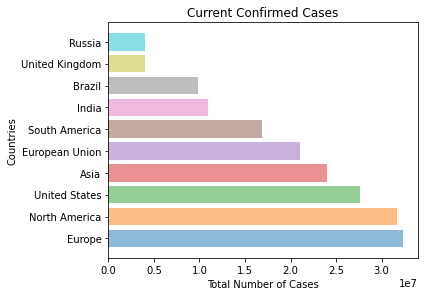

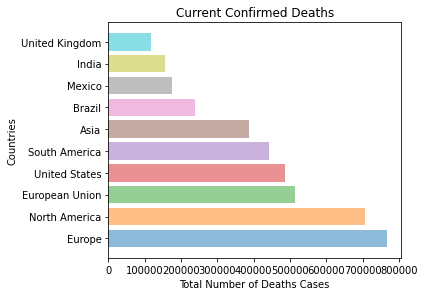

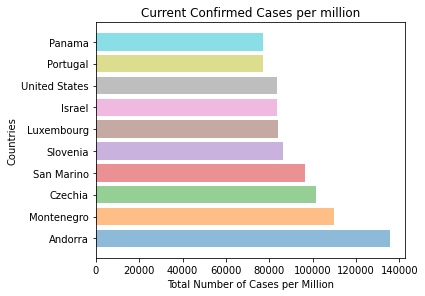

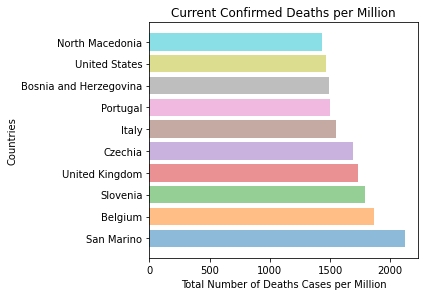

In [ ]:
bar_chart_compare_countries(top10cases,1)
bar_chart_compare_countries(top10deaths,2)
bar_chart_compare_countries(top10cases_per_million,3)
bar_chart_compare_countries(top10deaths_per_million,4)

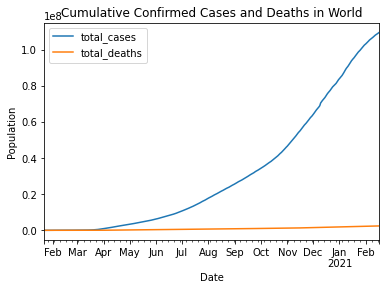

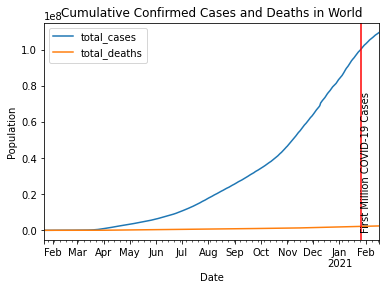

In [ ]:
#Time Series Data Visualisation - World
dv_cases_deaths("World",1)


ts_columns = ['total_cases', 'total_deaths']

timeseries_df = get_timeseries_per_country("World")

new_cases_num_df = timeseries_df[ts_columns]
new_cases_num_df.plot()

left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height

#plt.plot(timeseries_df.total_cases, color='blue')
#plt.plot(timeseries_df.total_deaths, color='orange')
plt.xlabel('Date')
plt.ylabel('Population')
plt.title('Cumulative Confirmed Cases and Deaths in {}'.format("World"))
x = new_cases_num_df.loc[new_cases_num_df.total_cases >= 100000000].head(1).index[0]
plt.axvline(pd.Timestamp(x), color='r')
plt.text(x, .5, "First Million COVID-19 Cases", rotation=90)
plt.show()

**Time Series Comparing Top 10 Countries**

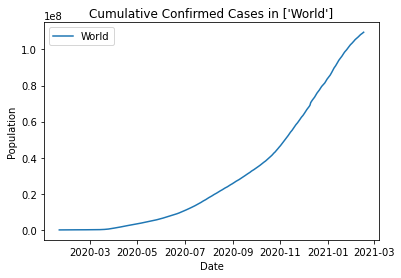

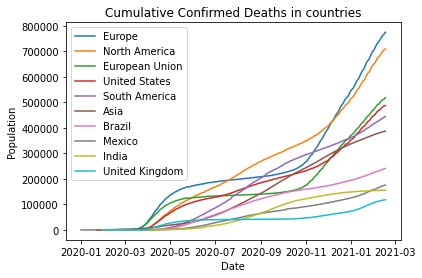

In [ ]:
dv_compare_cases_between_countries(['World'],'cases')
dv_compare_cases_between_countries(top10deaths,'deaths')

In [ ]:
world = get_timeseries_per_country("World")
world.loc[world.index == "2021-01-22"]

cases = world.loc[world.index == "2021-01-22"].total_cases[0]
deaths = world.loc[world.index == "2021-01-22"].total_deaths[0]

CFR = (deaths/cases)*100

print(CFR)

2.152984871729545


# **Load - Data Visualisation - Indonesia vs Other Countries**

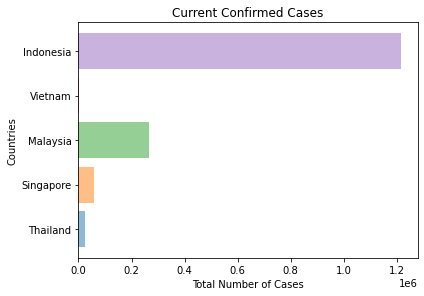

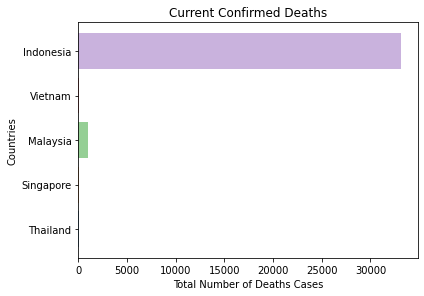

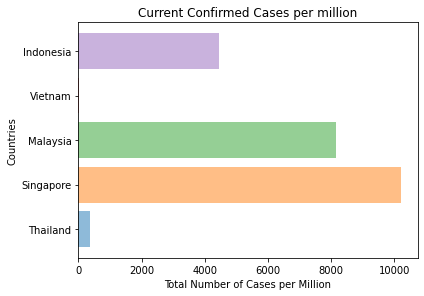

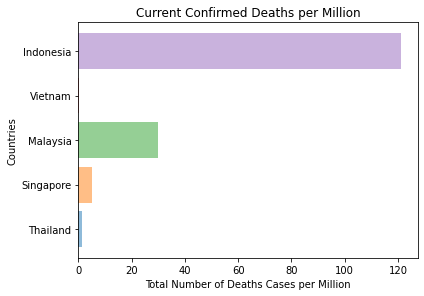

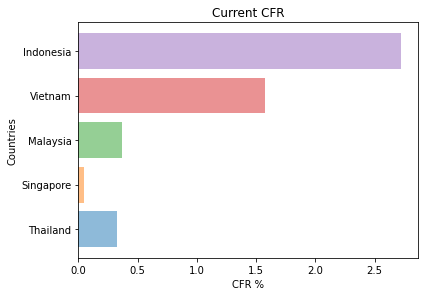

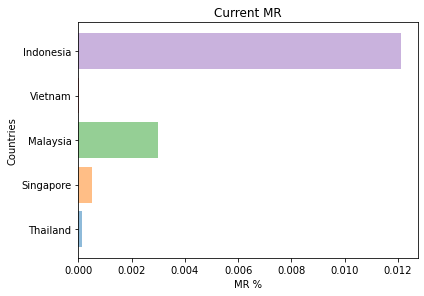

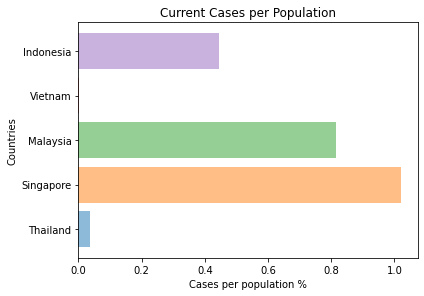

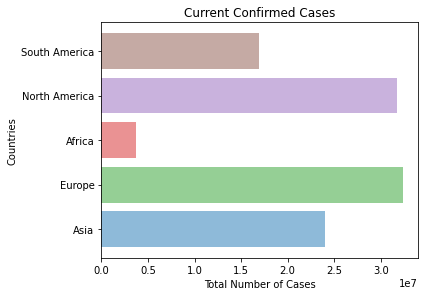

iso_code continent country_name  ...       CFR        MR  cases_per_population
0      SGP      Asia    Singapore  ...  0.000485  0.000005              0.010222

[1 rows x 43 columns]

In [ ]:
#List of ASEAN countries used for this research
ASEAN = ['Thailand', 'Singapore', 'Malaysia', 'Vietnam', 'Indonesia']

#List of all continents
continents = current_COVID_df.continent.unique().tolist()[:-1]

bar_chart_compare_countries(ASEAN,1)
bar_chart_compare_countries(ASEAN,2)
bar_chart_compare_countries(ASEAN,3)
bar_chart_compare_countries(ASEAN,4)
bar_chart_compare_countries(ASEAN,5)
bar_chart_compare_countries(ASEAN,6)
bar_chart_compare_countries(ASEAN,7)

bar_chart_compare_countries(continents, 1)

get_current_cases_country("Singapore")

In [ ]:
get_timeseries_per_country("Indonesia")

iso_code continent  ... life_expectancy  human_development_index
date                           ...                                         
2020-03-02      IDN      Asia  ...           71.72                    0.718
2020-03-03      IDN      Asia  ...           71.72                    0.718
2020-03-04      IDN      Asia  ...           71.72                    0.718
2020-03-05      IDN      Asia  ...           71.72                    0.718
2020-03-06      IDN      Asia  ...           71.72                    0.718
...             ...       ...  ...             ...                      ...
2021-02-12      IDN      Asia  ...           71.72                    0.718
2021-02-13      IDN      Asia  ...           71.72                    0.718
2021-02-14      IDN      Asia  ...           71.72                    0.718
2021-02-15      IDN      Asia  ...           71.72                    0.718
2021-02-16      IDN      Asia  ...           71.72                    0.718

[352 rows x 39 columns]

In [ ]:
#Visualise Time Series of number of cases and Government Response Index
#dv_compare_cases_between_countries(['Indonesia'], "new cases")

def dv_change_daily(country):
  df = get_timeseries_per_country("Indonesia")

  df.drop(df.tail(1).index,inplace=True)

  df_difference = []

  for i in range(len(df)-1):
    difference = df['new_cases'][i]-df['new_cases'][i-1] 
    if i == 0:
      df_difference.append({
          'date': df.index[i],
          'difference': df['new_cases'][i]-0
      })
    else:
      df_difference.append({
          'date': df.index[i],
          'difference': difference
      })

  difference_df = pd.DataFrame(df_difference)

  print(len(difference_df))

  plt.plot(difference_df, label = "Indonesia")

  plt.xlabel('Date')
  plt.ylabel('Population')
  plt.title('New Cases in {}'.format("Indonesia"))
  plt.legend(loc="upper left")
  plt.show()

#dv_change_daily("Indonesia")

#data_table.DataTable(df[['new_cases', 'daily_percentage_change_cases', 'log_daily_percentage_change_cases']])


No handles with labels found to put in legend.


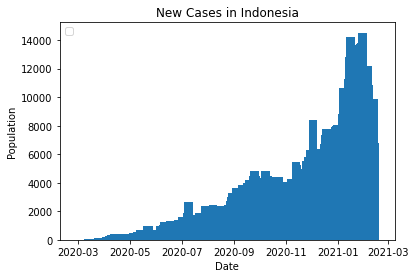

351
350


In [ ]:
#data_table.DataTable(df_dif)
df = get_timeseries_per_country("Indonesia")

df.drop(df.tail(1).index,inplace=True)

df_difference =[]

for i in range(len(df)-1):
  difference = df['new_cases'][i]-df['new_cases'][i-1]
  pct_change = 0 
  if difference == 0:
    pct_change = 0
  elif df['new_cases'][i-1] == 0:
    pct_change = 0
  else:
    pct_change = difference/df['new_cases'][i-1] 
  if i == 0:
    df_difference.append({
        'date': df.index[i],
        'difference': df['new_cases'][i]
    })
  else:
    df_difference.append({
        'date': df.index[i],
        'difference': df['new_cases'][i]
    })

difference_df = pd.DataFrame(df_difference)


max = difference_df.difference.max()
min = difference_df.difference.min()

difference_df.index = pd.to_datetime(difference_df.index)


#difference_df.plot(x='date')

ax = plt.subplot(111)
ax.bar(difference_df.date, difference_df.difference, width=10)
ax.xaxis_date()

plt.xlabel('Date')
plt.ylabel('Population')
plt.title('New Cases in {}'.format("Indonesia"))
plt.legend(loc="upper left")
plt.show()

print(len(df))
print(len(difference_df))

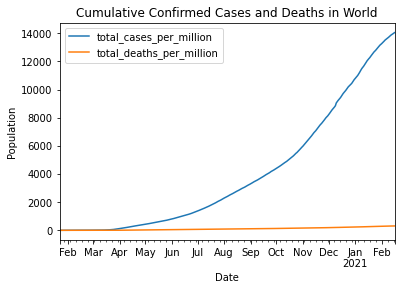

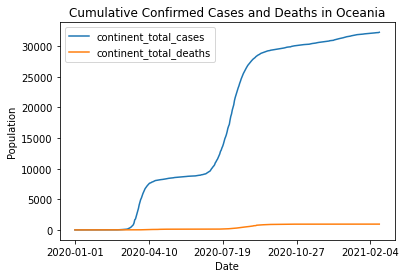

In [ ]:
dv_cases_deaths_per_million("World", 1)
dv_cases_deaths_per_million("Oceania", 2)

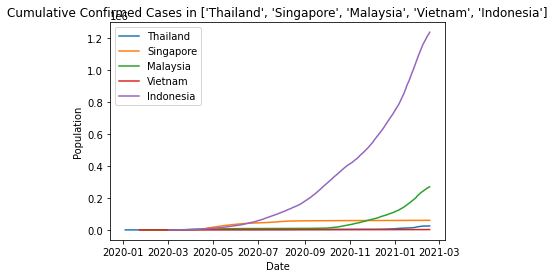

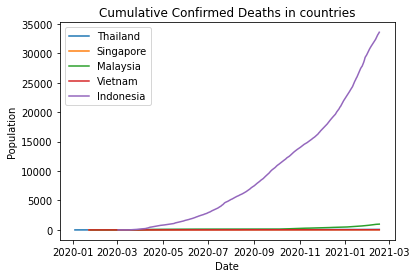

In [ ]:
dv_compare_cases_between_countries(ASEAN, "cases")
dv_compare_cases_between_countries(ASEAN, "deaths")

# **Load - Linear Regression, Correlation and Confidence Test**

In [ ]:
#Dates for 4 points to check the regression results
DATE_ONE = '2020-04-03'
DATE_TWO = '2020-08-03'
DATE_THREE = '2020-12-03'
DATE_FOUR = yesterday.strftime(DATE_FORMAT)

dates = [DATE_ONE, DATE_TWO, DATE_THREE, DATE_FOUR]

results_cor_coef = []

results_coef_det = []

def lin_reg(date):

  linear_regression_df = get_corr_lr_df(date)
  linear_regression_initial_df = get_corr_lr_df(DATE_ONE)

  linear_regression_df['rural_to_urban_ratio'] = np.log10(linear_regression_df['rural_population']/linear_regression_df['urban_population'])

  #linear_regression_df['log_GDP'] = np.log10(linear_regression_df['gdp_per_capita'])

  #Check correlation between each factor and current number of cases
  X = linear_regression_df['log10_cases_per_1mil'].values.reshape(-1,1)  
  Y = linear_regression_df['government_response_index_for_display'].values.reshape(-1,1) 

  x = linear_regression_df.log10_cases_per_1mil
  y = linear_regression_df.government_response_index_for_display

  cc = x.corr(y)

  reg = LinearRegression().fit(X, Y)  # create object for the class

  y_pred = reg.predict(X)

  plt.scatter(X, Y)
  plt.plot(X, y_pred, color='red')
  plt.title('Log Cases/1M vs Rural to Urban Ratio')
  plt.ylabel('Log Cases/1M')
  plt.xlabel('Rural : Urban')
  plt.show()

  cd = reg.score(X,Y)
  print("R: {}".format(cc))
  print("R2: {}".format(cd))




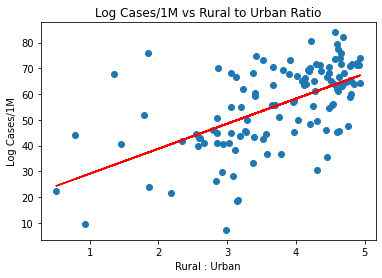

R: 0.578611122291652
R2: 0.3347908308396048


In [ ]:
lin_reg(DATE_FOUR)

import seaborn as sns

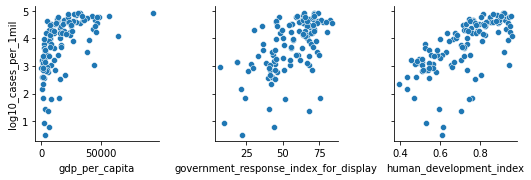

In [ ]:
linear_regression_df = get_corr_lr_df(DATE_FOUR)

sns.pairplot(linear_regression_df, 
             y_vars=['log10_cases_per_1mil'],
             x_vars = ['gdp_per_capita', 'government_response_index_for_display', 'human_development_index'])

**Check Correlation**

In [ ]:
lr = get_corr_lr_df(DATE_FOUR)
lr
#linear_regression_df.iloc[:, 2]

iso_code  ... log10_cases_per_1mil
0        AFG  ...             3.153964
1        ALB  ...             4.509772
2        DZA  ...             3.402211
3        AGO  ...             2.792156
4        ARG  ...             4.651498
..       ...  ...                  ...
117      VEN  ...             3.670695
118      VNM  ...             1.359627
119      YEM  ...             1.856832
120      ZMB  ...             3.577152
121      ZWE  ...             3.374093

[120 rows x 23 columns]

In [ ]:
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
linear_regression_df = get_corr_lr_df(DATE_FOUR)

#Check correlation between each factor and current number of cases
Y = linear_regression_df['log10_cases_per_1mil']  # values converts it into a numpy array
#X = linear_regression_df.total_cases_per_million.values.reshape(-1, 1)
X = linear_regression_df[['government_response_index_for_display', 'human_development_index']] # -1 means that calculate the dimension of rows, but have 1 column

reg = LinearRegression().fit(X, Y)  # create object for the class

y_pred = reg.predict(X)

y = linear_regression_df.log10_cases_per_1mil
x = linear_regression_df.government_response_index_for_display

cc = x.corr(y)

print("Correlation: {}".format(cc))

print("R2: {}".format(reg.score(X,Y)))

X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

Correlation: 0.578611122291652
R2: 0.5017469828915149
                             OLS Regression Results                             
Dep. Variable:     log10_cases_per_1mil   R-squared:                       0.502
Model:                              OLS   Adj. R-squared:                  0.493
Method:                   Least Squares   F-statistic:                     58.91
Date:                  Wed, 17 Feb 2021   Prob (F-statistic):           2.00e-18
Time:                          06:48:53   Log-Likelihood:                -124.45
No. Observations:                   120   AIC:                             254.9
Df Residuals:                       117   BIC:                             263.3
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

# **Machine Learning**

**Predicting COVID-19 cases based on Government Response Index**

In [ ]:
#Gets data frame for GRI only 
GRI_df = GR_df[['country_name','key','region_name','date', 'government_response_index_for_display']].copy()

In [ ]:
X_new_cases_million = timeseries_country_df.copy() 
X_new_cases_million = X_new_cases_million.loc[(timeseries_country_df.continent != 0) & (timeseries_country_df.country_name=="Indonesia")]
X_new_cases_million.set_index('date', inplace=True)

X_new_cases_million = add_PCT(X_new_cases_million, "Indonesia")

X_new_cases_million['daily_percentage_change_cases'] = X_new_cases_million['daily_percentage_change_cases'] * 100

#timeseries_country_df[['date','country_name','new_cases_per_million']].copy() 
#GRI_df

In [ ]:
X_new_cases_million.sort_index()

iso_code  ... daily_percentage_change_deaths
date                 ...                               
2020-03-02      IDN  ...                            NaN
2020-03-03      IDN  ...                            NaN
2020-03-04      IDN  ...                            NaN
2020-03-05      IDN  ...                            NaN
2020-03-06      IDN  ...                            NaN
...             ...  ...                            ...
2021-02-12      IDN  ...                       0.849263
2021-02-13      IDN  ...                       0.857423
2021-02-14      IDN  ...                       0.749939
2021-02-15      IDN  ...                       0.554501
2021-02-16      IDN  ...                       0.686307

[352 rows x 41 columns]

In [ ]:
X_new_cases_million.new_cases_per_million.plot()

**Autocorrelation**

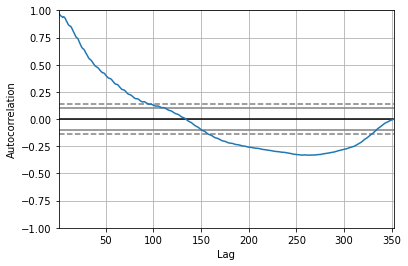

In [ ]:
pd.plotting.autocorrelation_plot(X_new_cases_million.new_cases)

In [ ]:
%pip install dtw

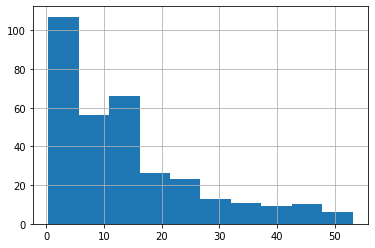

In [ ]:
d1 = X_new_cases_million.loc[X_new_cases_million.total_cases > 1000]['new_cases_per_million']
d1.hist()
#d1.plot()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

X= d1.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.513360
p-value: 0.889383
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572


#**Stocks Data Pre-Processing**

**Pre-Processing the list of companies from IDX**

In [ ]:
#Gets company list listed in IDX from IDX's (Indonesia Stock Exchange) website
#file_path = 'https://idx.co.id/media/8127/09_listed-companies-by-entry-point-2020-en.pdf'

#Converts and downloads the content from PDF to CSV so it can be uploaded to github
#and use pd.read_csv instead of calling tabula
#tabula.convert_into(file_path, 'company_list.csv',stream=True, pages='all')

In [ ]:
#Reads in the CSV file from github
file_path = 'https://raw.githubusercontent.com/filbertmiko/Analysis-of-COVID-19-and-its-Impact-on-IHSG-and-Rupiah/main/company_list.csv'

#Convert it into a pandas dataframe
company_list = pd.read_csv(file_path)

**Clean**

In [ ]:
#Cleaning dataframe
#Detele any NaNs
idx_company_list = company_list.dropna()

#Filter out unwanted records
idx_companies = idx_company_list[idx_company_list.No != "No"]

#Convert column's data type
convert_dict = {'Kode': str, 
                'Nama Perusahaan': str
               } 
  
idx_companies = idx_companies.astype(convert_dict) 
idx_companies = idx_companies.reset_index()

#Drop unwanted columns
idx_companies = idx_companies.drop(['index','No','Entry Point', 'Sektor', 'Subsektor'], axis=1)

#Rename columns
idx_companies = idx_companies.rename(columns={"Kode": "Symbol", "Nama Perusahaan": "Name"}, errors="raise")

In [ ]:
#Add IDX's extension for yfinance
#Example -> BBCA becomes BBCA.JK

JKSE_symbol = ".JK"
idx_companies['Symbol'] = idx_companies['Symbol'].astype(str) + JKSE_symbol

**Transform**

In [ ]:
#Get information for the inputted Symbol and
#Turns the returned values (dict) to dataframe

#Use a for loop to loop through the company list dataframe and then for each
#iteration, call the function, and combine the returned df to the bigger df
def turn_info_into_df(ticker):
  #Get information for the inputted Symbol and
  symbol = yf.Ticker(ticker)

  keys = [*symbol.info.keys()]
  values = [*symbol.info.values()]

  items = [keys, values]
  df = pd.DataFrame(items)
  new_header = df.iloc[0] #grab the first row for the header
  df = df[1:] #take the data less the header row
  df.columns = new_header #set the header row as the df header
  #df1 = df[['a', 'b']]
  df = df[['sector', 'city', 'longBusinessSummary', 'country', 'industry', 'previousClose']]
  
  return(df)

turn_info_into_df("BBCA.JK")

In [ ]:
#Combine table from idx_companies to the stock's details taken from yfinance